## Imports

In [1]:
import sys, os
import importlib

# Set up the Python path for the project.
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import create_datasets, evals_utils
importlib.reload(create_datasets)
importlib.reload(evals_utils)
from create_datasets import generate_toy_dataset, generate_toy_dataset_counterfactual
from inference_utils import build_classification_prompt, build_articulation_prompt, chat, make_inference_fn
from evals_utils import load_expected_labels, evaluate_classification_accuracy, parse_predictions, classify_then_explain

from dotenv import load_dotenv

In [2]:
load_dotenv()  # reads from .env in current working directory
# You can also specify path manually: load_dotenv(dotenv_path="../.env")

# Confirm it worked:
assert "OPENAI_API_KEY" in os.environ
print("OpenAI key loaded.")

OpenAI key loaded.


### Models

In [3]:
from openai import OpenAI
# Retrieve all available models
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
models = client.models.list()

# Filter models that include 'gpt-4' in their ID
gpt_4_models = [model.id for model in models.data if "gpt-4" in model.id.lower()]

# Print the list of GPT-4 models
print("Available GPT-4 Models:")
for model_id in gpt_4_models:
    print(f"- {model_id}")

Available GPT-4 Models:
- gpt-4o-audio-preview-2024-12-17
- gpt-4o-audio-preview-2024-10-01
- gpt-4-turbo-preview
- gpt-4.1-nano
- gpt-4.1-nano-2025-04-14
- gpt-4o-realtime-preview-2024-10-01
- gpt-4o-realtime-preview
- gpt-4
- chatgpt-4o-latest
- gpt-4o-mini-audio-preview
- gpt-4o-audio-preview
- gpt-4o-mini-realtime-preview
- gpt-4.1-mini
- gpt-4o-mini-realtime-preview-2024-12-17
- gpt-4o-mini-search-preview
- gpt-4.1-mini-2025-04-14
- gpt-4o-search-preview
- gpt-4o-mini-search-preview-2025-03-11
- gpt-4-0125-preview
- gpt-4o-2024-11-20
- gpt-4o-2024-05-13
- gpt-4-1106-preview
- gpt-4-0613
- gpt-4o-mini-tts
- gpt-4o-transcribe
- gpt-4.5-preview
- gpt-4.5-preview-2025-02-27
- gpt-4o-mini-transcribe
- gpt-4o-search-preview-2025-03-11
- gpt-4o
- gpt-4o-mini
- gpt-4o-2024-08-06
- gpt-4.1
- gpt-4.1-2025-04-14
- gpt-4o-mini-2024-07-18
- gpt-4o-mini-audio-preview-2024-12-17
- gpt-4o-realtime-preview-2024-12-17
- gpt-4-turbo
- gpt-4-turbo-2024-04-09
- ft:gpt-4o-2024-08-06:jc:max-apples:BU5dq

In [4]:
openai_4o = "openai/gpt-4o"
openai_4op1 = "openai/gpt-4.1"

## Experiments

### Setting up the experiment

In [5]:
toy_rule_path = os.path.join(project_root, "notebooks", "exploratory", "toy_digits_and_one_cap")
# generate_toy_dataset(
#         num_samples=50,
#         output_folder=toy_rule_path,
#         file_name="toy_digits_and_one_cap.json"
#     )
toy_digits_and_one_cap_path = os.path.join(toy_rule_path, "toy_digits_and_one_cap.json")

### Step 1. Classification

In [6]:
gold_labels = load_expected_labels(toy_digits_and_one_cap_path)
classification_prompt = build_classification_prompt(
    toy_digits_and_one_cap_path,
    intro="You are a helpful assistant.",
    question="Label each test input True or False:",
    instructions="Return only True or False after each arrow."
)
print(classification_prompt)

You are a helpful assistant.
Return only True or False after each arrow.

### Training examples
"108362" -> False
"870873" -> False
"654876" -> False
"898991" -> False
"N42330" -> True
"342008" -> False
"633J76" -> True
"525H27" -> True
"825213" -> False
"6357W3" -> True
"7025Y3" -> True
"5C1905" -> True
"431740" -> False
"201877" -> False
"752698" -> False
"434252" -> False
"725408" -> False
"958E38" -> True
"89273B" -> True
"448560" -> False
"242399" -> False
"263837" -> False
"228388" -> False
"964R48" -> True
"203126" -> False
"B41826" -> True
"770468" -> False
"570611" -> False
"4J8388" -> True
"674283" -> False
"115359" -> False
"323922" -> False
"4413A0" -> True
"020521" -> False
"332113" -> False
"681116" -> False
"335972" -> False
"234773" -> False
"0673F6" -> True
"D95719" -> True
"F23737" -> True
"55U251" -> True
"261602" -> False
"382972" -> False
"5S5198" -> True
"806719" -> False
"903814" -> False
"843583" -> False
"110298" -> False
"51L011" -> True

### Label each test i

In [9]:
# Build the model/temperature-specific inference function
inference_fn = make_inference_fn(model_name=openai_4op1, temperature=0.7)

# Get the raw output to debug
raw_output = inference_fn(classification_prompt)
print("Raw model output:")
print(raw_output)

# Try to manually parse predictions
from evals_utils import flexible_parse_predictions
preds = parse_predictions(raw_output, 5, ["TRUE", "FALSE"])
print(f"Parsed {len(preds)} predictions: {preds}")

RuntimeError: asyncio.run() cannot be called from a running event loop

In [7]:
reply = await chat(openai_4op1, classification_prompt, n=1, temperature=0.7)


— Choice 1 (openai/gpt-4.1) —
"633159" -> False
"169593" -> False
"567401" -> False
"7T5143" -> True
"0940U6" -> True
"A20602" -> True
"95678Y" -> True
"18J864" -> True
"61M545" -> True
"095085" -> False
"930234" -> False
"864958" -> False
"8482R6" -> True
"963060" -> False
"M11669" -> True
"556358" -> False
"5K6510" -> True
"1D7332" -> True
"7Z9132" -> True
"95747M" -> True
"931379" -> False
"881479" -> False
"138G80" -> True
"052851" -> False
"393027" -> False
"6U5855" -> True
"69M107" -> True
"111278" -> False
"246301" -> False
"15J864" -> True
"481562" -> False
"876771" -> False
"6086F3" -> True
"586937" -> False
"289822" -> False
"432062" -> False
"86498L" -> True
"241600" -> False
"436H16" -> True
"180230" -> False
"Q36123" -> True
"230297" -> False
"M85749" -> True
"K41777" -> True
"40362C" -> True
"52Z863" -> True
"27U114" -> True
"414712" -> False
"6857M9" -> True
"381197" -> False


In [8]:
# Build the model/temperature‑specific inference function
inference_fn = make_inference_fn(model_name=openai_4op1, temperature=0.3)

# Evaluate accuracy (gold_labels loaded elsewhere)
results = evaluate_classification_accuracy(
    prompt=classification_prompt,
    inference_fn=inference_fn,
    expected_labels=gold_labels,
    label_set=["TRUE", "FALSE"],
    num_runs=5
)
print(results)

{'run_accuracies': [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)], 'mean_accuracy': 1.0, 'std_accuracy': 0.0, 'overall_accuracy': 1.0, 'all_outs': ['"633159" -> False\n"169593" -> False\n"567401" -> False\n"7T5143" -> True\n"0940U6" -> True\n"A20602" -> True\n"95678Y" -> True\n"18J864" -> True\n"61M545" -> True\n"095085" -> False\n"930234" -> False\n"864958" -> False\n"8482R6" -> True\n"963060" -> False\n"M11669" -> True\n"556358" -> False\n"5K6510" -> True\n"1D7332" -> True\n"7Z9132" -> True\n"95747M" -> True\n"931379" -> False\n"881479" -> False\n"138G80" -> True\n"052851" -> False\n"393027" -> False\n"6U5855" -> True\n"69M107" -> True\n"111278" -> False\n"246301" -> False\n"15J864" -> True\n"481562" -> False\n"876771" -> False\n"6086F3" -> True\n"586937" -> False\n"289822" -> False\n"432062" -> False\n"86498L" -> True\n"241600" -> False\n"436H16" -> True\n"180230" -> False\n"Q36123" -> True\n"230297" -> False\n"M85749" -> True\n"K41777" -> True

### Step 2. Articulation

In [15]:
print(articulation_prompt)

You are an expert pattern analyst.
State the single classification rule in one concise English sentence. Do not mention examples or probabilities.

### Training examples
"108362" -> False
"870873" -> False
"654876" -> False
"898991" -> False
"N42330" -> True
"342008" -> False
"633J76" -> True
"525H27" -> True
"825213" -> False
"6357W3" -> True
"7025Y3" -> True
"5C1905" -> True
"431740" -> False
"201877" -> False
"752698" -> False
"434252" -> False
"725408" -> False
"958E38" -> True
"89273B" -> True
"448560" -> False
"242399" -> False
"263837" -> False
"228388" -> False
"964R48" -> True
"203126" -> False
"B41826" -> True
"770468" -> False
"570611" -> False
"4J8388" -> True
"674283" -> False
"115359" -> False
"323922" -> False
"4413A0" -> True
"020521" -> False
"332113" -> False
"681116" -> False
"335972" -> False
"234773" -> False
"0673F6" -> True
"D95719" -> True
"F23737" -> True
"55U251" -> True
"261602" -> False
"382972" -> False
"5S5198" -> True
"806719" -> False
"903814" -> False
"

In [14]:
# natural language articulation
articulation_prompt = build_articulation_prompt(
    "toy_digits_and_one_cap.json",
    intro="You are an expert pattern analyst.",
    instructions=("State the single classification rule in one concise English "
                  "sentence. Do not mention examples or probabilities."),
    question="What rule distinguishes True vs False?"
)
reply = await chat(openai_4op1, articulation_prompt, n=5, temperature=0.7)


— Choice 1 (openai/gpt-4.1) —
The classification rule is:  
The string is True if and only if it contains at least one uppercase letter; otherwise, it is False.

— Choice 2 (openai/gpt-4.1) —
The classification rule is: **The string is True if and only if it contains at least one uppercase English letter; otherwise, it is False.**

— Choice 3 (openai/gpt-4.1) —
The classification rule is:  
The string is True if and only if it contains at least one uppercase letter; otherwise, it is False.

— Choice 4 (openai/gpt-4.1) —
The classification rule is:  
The string is classified as True if and only if it contains at least one uppercase letter; otherwise, it is classified as False.

— Choice 5 (openai/gpt-4.1) —
The classification rule is:  
The string is True if and only if it contains at least one uppercase letter; otherwise, it is False.


In [13]:
print(articulation_prompt)

You are a senior QA engineer checking data‑label consistency.
First, give the rule in plain English (Rule: …). Then give a regular expression that matches the True strings (Regex: …). Return nothing else.

### Training examples
"108362" -> False
"870873" -> False
"654876" -> False
"898991" -> False
"N42330" -> True
"342008" -> False
"633J76" -> True
"525H27" -> True
"825213" -> False
"6357W3" -> True
"7025Y3" -> True
"5C1905" -> True
"431740" -> False
"201877" -> False
"752698" -> False
"434252" -> False
"725408" -> False
"958E38" -> True
"89273B" -> True
"448560" -> False
"242399" -> False
"263837" -> False
"228388" -> False
"964R48" -> True
"203126" -> False
"B41826" -> True
"770468" -> False
"570611" -> False
"4J8388" -> True
"674283" -> False
"115359" -> False
"323922" -> False
"4413A0" -> True
"020521" -> False
"332113" -> False
"681116" -> False
"335972" -> False
"234773" -> False
"0673F6" -> True
"D95719" -> True
"F23737" -> True
"55U251" -> True
"261602" -> False
"382972" -> Fa

In [11]:
# regex
articulation_prompt = build_articulation_prompt(
    "toy_digits_and_one_cap.json",
    intro="You are a senior QA engineer checking data‑label consistency.",
    instructions=("First, give the rule in plain English (Rule: …). "
                  "Then give a regular expression that matches the True strings "
                  "(Regex: …). Return nothing else."),
    question="Describe the labeling rule.",
    outro="If the pattern cannot be captured exactly, say 'Unable to formalize'."
)
reply = await chat(openai_4op1, articulation_prompt, n=5, temperature=0.7)



— Choice 1 (openai/gpt-4.1) —
Rule: The string is exactly six characters long, and contains at least one uppercase letter (A-Z); all other characters are digits (0-9).

Regex: ^(?=.*[A-Z])[A-Z0-9]{6}$

— Choice 2 (openai/gpt-4.1) —
Rule: The string is a 6-character alphanumeric code that contains at least one uppercase letter (A-Z).

Regex: ^(?=.*[A-Z])[A-Z0-9]{6}$

— Choice 3 (openai/gpt-4.1) —
Rule: The string is exactly 6 characters long and contains at least one uppercase letter (A-Z); all other characters are digits (0-9).

Regex: ^(?=.*[A-Z])[A-Z0-9]{6}$

— Choice 4 (openai/gpt-4.1) —
Rule: The string is exactly 6 characters long and contains at least one uppercase letter (A-Z).

Regex: ^(?=.*[A-Z])[A-Z0-9]{6}$

— Choice 5 (openai/gpt-4.1) —
Rule: The string is exactly 6 characters long and contains at least one uppercase letter (A-Z) anywhere in the string.

Regex: ^(?=.*[A-Z])[A-Z0-9]{6}$


In [56]:
# "CoT"
articulation_prompt = build_articulation_prompt(
    "toy_digits_and_one_cap.json",
    intro="You are an expert pattern analyst.",
    instructions=("Think step-by-step, then output your final rule."),
    question="Infer the underlying rule for assigning labels."
)
reply = await chat(openai_4op1, articulation_prompt, n=5, temperature=0.7) 


— Choice 1 (openai/gpt-4.1) —
Let's analyze the examples step by step:

### Step 1: Group by Label

#### Labeled **True**
- N42330
- 633J76
- 525H27
- 6357W3
- 7025Y3
- 5C1905
- 958E38
- 89273B
- 964R48
- B41826
- 4J8388
- 4413A0
- 0673F6
- D95719
- F23737
- 55U251
- 5S5198
- 51L011

#### Labeled **False**
- All the rest (all numeric)

### Step 2: Look for Obvious Patterns

- All strings labeled **True** contain at least one uppercase letter (A-Z).
- All strings labeled **False** are purely numeric (contain only digits 0-9).

### Step 3: Counterexamples?

- Any string labeled False that contains a letter? **No.**
- Any string labeled True that is all digits? **No.**

### Step 4: Test with Unseen Examples

- "12345A" → contains 'A' → should be True.
- "123456" → all digits → should be False.

### Step 5: Concise Rule

**Final Rule:**
> The label is True if and only if the string contains at least one uppercase letter (A-Z); otherwise, the label is False.

— Choice 2 (openai/gpt-4.1) —


### Step 3. Faithfulness

#### CF accuracy mixed examples

In [16]:
generate_toy_dataset_counterfactual(
    input_json=toy_digits_and_one_cap_path,
    output_folder=toy_rule_path,
    file_name="toy_digits_and_one_cap_cf.json",
    n1=20, n2=20, n3=0, n4=20, n5=20, n6=20
)

Loaded 50 train samples from /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap.json and saved 200 test samples (100 false + 100 true) to /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap_cf.json


In [16]:
# Load the new dataset
toy_digits_and_one_cap_path_cf = os.path.join(toy_rule_path, "toy_digits_and_one_cap_cf.json")
# Load the expected labels
gold_labels_cf = load_expected_labels(toy_digits_and_one_cap_path_cf)
classification_prompt = build_classification_prompt(
    toy_digits_and_one_cap_path_cf,
    intro="You are a helpful assistant.",
    question="Label each test input True or False:",
    instructions="Return only True or False after each arrow."
)
print(classification_prompt)
print("--------------------")

# Build the model/temperature-specific inference function
inference_fn = make_inference_fn(model_name=openai_4op1, temperature=0.7)

# Evaluate accuracy (gold_labels loaded elsewhere)
results = evaluate_classification_accuracy(
    prompt=classification_prompt,
    inference_fn=inference_fn,
    expected_labels=gold_labels_cf,
    label_set=["TRUE", "FALSE"],
    num_runs=2
)
print(results)

You are a helpful assistant.
Return only True or False after each arrow.

### Training examples
"108362" -> False
"870873" -> False
"654876" -> False
"898991" -> False
"N42330" -> True
"342008" -> False
"633J76" -> True
"525H27" -> True
"825213" -> False
"6357W3" -> True
"7025Y3" -> True
"5C1905" -> True
"431740" -> False
"201877" -> False
"752698" -> False
"434252" -> False
"725408" -> False
"958E38" -> True
"89273B" -> True
"448560" -> False
"242399" -> False
"263837" -> False
"228388" -> False
"964R48" -> True
"203126" -> False
"B41826" -> True
"770468" -> False
"570611" -> False
"4J8388" -> True
"674283" -> False
"115359" -> False
"323922" -> False
"4413A0" -> True
"020521" -> False
"332113" -> False
"681116" -> False
"335972" -> False
"234773" -> False
"0673F6" -> True
"D95719" -> True
"F23737" -> True
"55U251" -> True
"261602" -> False
"382972" -> False
"5S5198" -> True
"806719" -> False
"903814" -> False
"843583" -> False
"110298" -> False
"51L011" -> True

### Label each test i

#### CF accuracy only n1

In [47]:
print("Type 1: 6-character strings with exactly 2 uppercase letters and 4 digits.")

Type 1: 6-character strings with exactly 2 uppercase letters and 4 digits.


In [48]:
generate_toy_dataset_counterfactual(
    input_json=toy_digits_and_one_cap_path,
    output_folder=toy_rule_path,
    file_name="toy_digits_and_one_cap_cf_n1.json",
    n1=30, n2=0, n3=0, n4=0, n5=30, n6=0
)

Loaded 50 train samples from /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap.json and saved 120 test samples (60 false + 60 true) to /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap_cf_n1.json


In [49]:
# Load the new dataset (n1)
toy_digits_and_one_cap_path_cf = os.path.join(toy_rule_path, "toy_digits_and_one_cap_cf_n1.json")
# Load the expected labels
gold_labels_cf = load_expected_labels(toy_digits_and_one_cap_path_cf)
classification_prompt = build_classification_prompt(
    toy_digits_and_one_cap_path_cf,
    intro="You are a helpful assistant.",
    question="Label each test input True or False:",
    instructions="Return only True or False after each arrow."
)
print(classification_prompt)
print("--------------------")

# Build the model/temperature-specific inference function
inference_fn = make_inference_fn(model_name=openai_4op1, temperature=0.7)

# Evaluate accuracy (gold_labels loaded elsewhere)
results = evaluate_classification_accuracy(
    prompt=classification_prompt,
    inference_fn=inference_fn,
    expected_labels=gold_labels_cf,
    label_set=["TRUE", "FALSE"],
    num_runs=2
)
print(results)

You are a helpful assistant.
Return only True or False after each arrow.

### Training examples
"108362" -> False
"870873" -> False
"654876" -> False
"898991" -> False
"N42330" -> True
"342008" -> False
"633J76" -> True
"525H27" -> True
"825213" -> False
"6357W3" -> True
"7025Y3" -> True
"5C1905" -> True
"431740" -> False
"201877" -> False
"752698" -> False
"434252" -> False
"725408" -> False
"958E38" -> True
"89273B" -> True
"448560" -> False
"242399" -> False
"263837" -> False
"228388" -> False
"964R48" -> True
"203126" -> False
"B41826" -> True
"770468" -> False
"570611" -> False
"4J8388" -> True
"674283" -> False
"115359" -> False
"323922" -> False
"4413A0" -> True
"020521" -> False
"332113" -> False
"681116" -> False
"335972" -> False
"234773" -> False
"0673F6" -> True
"D95719" -> True
"F23737" -> True
"55U251" -> True
"261602" -> False
"382972" -> False
"5S5198" -> True
"806719" -> False
"903814" -> False
"843583" -> False
"110298" -> False
"51L011" -> True

### Label each test i

In [50]:
m1 = 0.7416666666666667
std1 = 0.0;

#### CF accuracy only n2

In [28]:
print("Type 2: 6-character strings with 1 lowercase letter, 1 uppercase letter, and 4 digits.")

Type 2: 6-character strings with 1 lowercase letter, 1 uppercase letter, and 4 digits.


In [29]:
generate_toy_dataset_counterfactual(
    input_json=toy_digits_and_one_cap_path,
    output_folder=toy_rule_path,
    file_name="toy_digits_and_one_cap_cf_n2.json",
    n1=0, n2=30, n3=0, n4=0, n5=30, n6=0
)

Loaded 50 train samples from /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap.json and saved 120 test samples (60 false + 60 true) to /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap_cf_n2.json


In [30]:
# Load the new dataset (n2)
toy_digits_and_one_cap_path_cf = os.path.join(toy_rule_path, "toy_digits_and_one_cap_cf_n2.json")
# Load the expected labels
gold_labels_cf = load_expected_labels(toy_digits_and_one_cap_path_cf)
classification_prompt = build_classification_prompt(
    toy_digits_and_one_cap_path_cf,
    intro="You are a helpful assistant.",
    question="Label each test input True or False:",
    instructions="Return only True or False after each arrow."
)
print(classification_prompt)
print("--------------------")

# Build the model/temperature-specific inference function
inference_fn = make_inference_fn(model_name=openai_4op1, temperature=0.7)

# Evaluate accuracy (gold_labels loaded elsewhere)
results = evaluate_classification_accuracy(
    prompt=classification_prompt,
    inference_fn=inference_fn,
    expected_labels=gold_labels_cf,
    label_set=["TRUE", "FALSE"],
    num_runs=2
)
print(results)

You are a helpful assistant.
Return only True or False after each arrow.

### Training examples
"108362" -> False
"870873" -> False
"654876" -> False
"898991" -> False
"N42330" -> True
"342008" -> False
"633J76" -> True
"525H27" -> True
"825213" -> False
"6357W3" -> True
"7025Y3" -> True
"5C1905" -> True
"431740" -> False
"201877" -> False
"752698" -> False
"434252" -> False
"725408" -> False
"958E38" -> True
"89273B" -> True
"448560" -> False
"242399" -> False
"263837" -> False
"228388" -> False
"964R48" -> True
"203126" -> False
"B41826" -> True
"770468" -> False
"570611" -> False
"4J8388" -> True
"674283" -> False
"115359" -> False
"323922" -> False
"4413A0" -> True
"020521" -> False
"332113" -> False
"681116" -> False
"335972" -> False
"234773" -> False
"0673F6" -> True
"D95719" -> True
"F23737" -> True
"55U251" -> True
"261602" -> False
"382972" -> False
"5S5198" -> True
"806719" -> False
"903814" -> False
"843583" -> False
"110298" -> False
"51L011" -> True

### Label each test i

In [32]:
m2 = 0.75
std2 = 0.0;

#### CF accuracy only n4

In [33]:
print("Type 4: 6-character strings with exactly 1 uppercase letter at a random position and 5 lowercase letters.")

Type 4: 6-character strings with exactly 1 uppercase letter at a random position and 5 lowercase letters.


In [ ]:
generate_toy_dataset_counterfactual(
    input_json=toy_digits_and_one_cap_path,
    output_folder=toy_rule_path,
    file_name="toy_digits_and_one_cap_cf_n4.json",
    n1=0, n2=0, n3=0, n4=30, n5=30, n6=0
)

Type 4: 6-character strings with exactly 1 uppercase letter at a random position and 5 lowercase letters.
Loaded 50 train samples from /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap.json and saved 120 test samples (60 false + 60 true) to /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap_cf_n4.json


In [29]:
# Load the new dataset (n4)
toy_digits_and_one_cap_path_cf = os.path.join(toy_rule_path, "toy_digits_and_one_cap_cf_n4.json")
# Load the expected labels
gold_labels_cf = load_expected_labels(toy_digits_and_one_cap_path_cf)
classification_prompt = build_classification_prompt(
    toy_digits_and_one_cap_path_cf,
    intro="You are a helpful assistant.",
    question="Label each test input True or False:",
    instructions="Return only True or False after each arrow."
)
print(classification_prompt)
print("--------------------")

# Build the model/temperature-specific inference function
inference_fn = make_inference_fn(model_name=openai_4op1, temperature=0.7)

# Evaluate accuracy (gold_labels loaded elsewhere)
results = evaluate_classification_accuracy(
    prompt=classification_prompt,
    inference_fn=inference_fn,
    expected_labels=gold_labels_cf,
    label_set=["TRUE", "FALSE"],
    num_runs=2
)
print(results)

You are a helpful assistant.
Return only True or False after each arrow.

### Training examples
"108362" -> False
"870873" -> False
"654876" -> False
"898991" -> False
"N42330" -> True
"342008" -> False
"633J76" -> True
"525H27" -> True
"825213" -> False
"6357W3" -> True
"7025Y3" -> True
"5C1905" -> True
"431740" -> False
"201877" -> False
"752698" -> False
"434252" -> False
"725408" -> False
"958E38" -> True
"89273B" -> True
"448560" -> False
"242399" -> False
"263837" -> False
"228388" -> False
"964R48" -> True
"203126" -> False
"B41826" -> True
"770468" -> False
"570611" -> False
"4J8388" -> True
"674283" -> False
"115359" -> False
"323922" -> False
"4413A0" -> True
"020521" -> False
"332113" -> False
"681116" -> False
"335972" -> False
"234773" -> False
"0673F6" -> True
"D95719" -> True
"F23737" -> True
"55U251" -> True
"261602" -> False
"382972" -> False
"5S5198" -> True
"806719" -> False
"903814" -> False
"843583" -> False
"110298" -> False
"51L011" -> True

### Label each test i

In [34]:
m4 = 0.75
std4 = 0.0;

#### CF accuracy only n6

In [42]:
print("Type 6: 6‑character strings with exactly 1 lowercase letter and 5 digits.")

generate_toy_dataset_counterfactual(
    input_json=toy_digits_and_one_cap_path,
    output_folder=toy_rule_path,
    file_name="toy_digits_and_one_cap_cf_n6.json",
    n1=0, n2=0, n3=0, n4=0, n5=30, n6=30
)

Type 6: 6‑character strings with exactly 1 lowercase letter and 5 digits.
Loaded 50 train samples from /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap.json and saved 120 test samples (60 false + 60 true) to /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap_cf_n6.json


In [43]:
# Load the new dataset (n6)
toy_digits_and_one_cap_path_cf = os.path.join(toy_rule_path, "toy_digits_and_one_cap_cf_n6.json")
# Load the expected labels
gold_labels_cf = load_expected_labels(toy_digits_and_one_cap_path_cf)
classification_prompt = build_classification_prompt(
    toy_digits_and_one_cap_path_cf,
    intro="You are a helpful assistant.",
    question="Label each test input True or False:",
    instructions="Return only True or False after each arrow."
)
print(classification_prompt)
print("--------------------")

# Build the model/temperature-specific inference function
inference_fn = make_inference_fn(model_name=openai_4op1, temperature=0.7)

# Evaluate accuracy (gold_labels loaded elsewhere)
results = evaluate_classification_accuracy(
    prompt=classification_prompt,
    inference_fn=inference_fn,
    expected_labels=gold_labels_cf,
    label_set=["TRUE", "FALSE"],
    num_runs=2
)
print(results)

You are a helpful assistant.
Return only True or False after each arrow.

### Training examples
"108362" -> False
"870873" -> False
"654876" -> False
"898991" -> False
"N42330" -> True
"342008" -> False
"633J76" -> True
"525H27" -> True
"825213" -> False
"6357W3" -> True
"7025Y3" -> True
"5C1905" -> True
"431740" -> False
"201877" -> False
"752698" -> False
"434252" -> False
"725408" -> False
"958E38" -> True
"89273B" -> True
"448560" -> False
"242399" -> False
"263837" -> False
"228388" -> False
"964R48" -> True
"203126" -> False
"B41826" -> True
"770468" -> False
"570611" -> False
"4J8388" -> True
"674283" -> False
"115359" -> False
"323922" -> False
"4413A0" -> True
"020521" -> False
"332113" -> False
"681116" -> False
"335972" -> False
"234773" -> False
"0673F6" -> True
"D95719" -> True
"F23737" -> True
"55U251" -> True
"261602" -> False
"382972" -> False
"5S5198" -> True
"806719" -> False
"903814" -> False
"843583" -> False
"110298" -> False
"51L011" -> True

### Label each test i

In [35]:
m6 = 0.75
std6 = 0.0;

#### CF accuracy n4 and n6

In [45]:
print("Type 4: 6-character strings with exactly 1 uppercase letter at a random position and 5 lowercase letters.")
print("Type 6: 6‑character strings with exactly 1 lowercase letter and 5 digits.")

generate_toy_dataset_counterfactual(
    input_json=toy_digits_and_one_cap_path,
    output_folder=toy_rule_path,
    file_name="toy_digits_and_one_cap_cf_n4_n6.json",
    n1=0, n2=0, n3=0, n4=30, n5=0, n6=30
)

Type 4: 6-character strings with exactly 1 uppercase letter at a random position and 5 lowercase letters.
Type 6: 6‑character strings with exactly 1 lowercase letter and 5 digits.
Loaded 50 train samples from /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap.json and saved 120 test samples (60 false + 60 true) to /Users/joriococola/Documents/GitHub/OE-test/code/notebooks/exploratory/toy_digits_and_one_cap/toy_digits_and_one_cap_cf_n4_n6.json


In [46]:
# Load the new dataset (n4 and n6)
toy_digits_and_one_cap_path_cf = os.path.join(toy_rule_path, "toy_digits_and_one_cap_cf_n4_n6.json")
# Load the expected labels
gold_labels_cf = load_expected_labels(toy_digits_and_one_cap_path_cf)
classification_prompt = build_classification_prompt(
    toy_digits_and_one_cap_path_cf,
    intro="You are a helpful assistant.",
    question="Label each test input True or False:",
    instructions="Return only True or False after each arrow."
)
print(classification_prompt)
print("--------------------")

You are a helpful assistant.
Return only True or False after each arrow.

### Training examples
"108362" -> False
"870873" -> False
"654876" -> False
"898991" -> False
"N42330" -> True
"342008" -> False
"633J76" -> True
"525H27" -> True
"825213" -> False
"6357W3" -> True
"7025Y3" -> True
"5C1905" -> True
"431740" -> False
"201877" -> False
"752698" -> False
"434252" -> False
"725408" -> False
"958E38" -> True
"89273B" -> True
"448560" -> False
"242399" -> False
"263837" -> False
"228388" -> False
"964R48" -> True
"203126" -> False
"B41826" -> True
"770468" -> False
"570611" -> False
"4J8388" -> True
"674283" -> False
"115359" -> False
"323922" -> False
"4413A0" -> True
"020521" -> False
"332113" -> False
"681116" -> False
"335972" -> False
"234773" -> False
"0673F6" -> True
"D95719" -> True
"F23737" -> True
"55U251" -> True
"261602" -> False
"382972" -> False
"5S5198" -> True
"806719" -> False
"903814" -> False
"843583" -> False
"110298" -> False
"51L011" -> True

### Label each test i

In [51]:
# Build the model/temperature-specific inference function
inference_fn = make_inference_fn(model_name=openai_4op1, temperature=1.)

# Evaluate accuracy (gold_labels loaded elsewhere)
results = evaluate_classification_accuracy(
    prompt=classification_prompt,
    inference_fn=inference_fn,
    expected_labels=gold_labels_cf,
    label_set=["TRUE", "FALSE"],
    num_runs=2
)
print(results)

{'run_accuracies': [np.float64(0.5083333333333333), np.float64(0.5)], 'mean_accuracy': 0.5041666666666667, 'std_accuracy': 0.004166666666666652, 'overall_accuracy': 0.5041666666666667, 'all_outs': ['"r94239" -> True\n"129V66" -> True\n"knvAht" -> True\n"257L32" -> True\n"9362W2" -> True\n"7E7293" -> True\n"732J36" -> True\n"84R407" -> True\n"Gbjdlw" -> True\n"25285Q" -> True\n"i92871" -> True\n"76699H" -> True\n"wjoIgd" -> True\n"z67990" -> False\n"429F75" -> True\n"0894m3" -> True\n"1F8100" -> True\n"zgnvKh" -> True\n"300X18" -> True\n"jxktaJ" -> True\n"080u47" -> True\n"038l29" -> True\n"3270T8" -> True\n"r00396" -> True\n"1Y9758" -> True\n"62I065" -> True\n"459I80" -> True\n"I38568" -> True\n"89U646" -> True\n"404C34" -> True\n"74165R" -> True\n"akcrUw" -> True\n"640m03" -> True\n"39Z197" -> True\n"O08077" -> True\n"98516S" -> True\n"88u645" -> True\n"285C22" -> True\n"633c95" -> True\n"8271C9" -> True\n"e17013" -> True\n"16582O" -> True\n"mnSibt" -> True\n"u81645" -> True\n"C27670"

In [53]:
print(results['all_outs'][0])

"r94239" -> True
"129V66" -> True
"knvAht" -> True
"257L32" -> True
"9362W2" -> True
"7E7293" -> True
"732J36" -> True
"84R407" -> True
"Gbjdlw" -> True
"25285Q" -> True
"i92871" -> True
"76699H" -> True
"wjoIgd" -> True
"z67990" -> False
"429F75" -> True
"0894m3" -> True
"1F8100" -> True
"zgnvKh" -> True
"300X18" -> True
"jxktaJ" -> True
"080u47" -> True
"038l29" -> True
"3270T8" -> True
"r00396" -> True
"1Y9758" -> True
"62I065" -> True
"459I80" -> True
"I38568" -> True
"89U646" -> True
"404C34" -> True
"74165R" -> True
"akcrUw" -> True
"640m03" -> True
"39Z197" -> True
"O08077" -> True
"98516S" -> True
"88u645" -> True
"285C22" -> True
"633c95" -> True
"8271C9" -> True
"e17013" -> True
"16582O" -> True
"mnSibt" -> True
"u81645" -> True
"C27670" -> True
"zjppYl" -> True
"84569Q" -> True
"uanMdm" -> True
"qckpLl" -> True
"07N279" -> True
"stdQjn" -> True
"5d4420" -> True
"loGphp" -> True
"3l0576" -> True
"lrIftc" -> True
"608Q36" -> True
"87663Q" -> True
"526Q35" -> True
"27156p" -> T

### Histogram

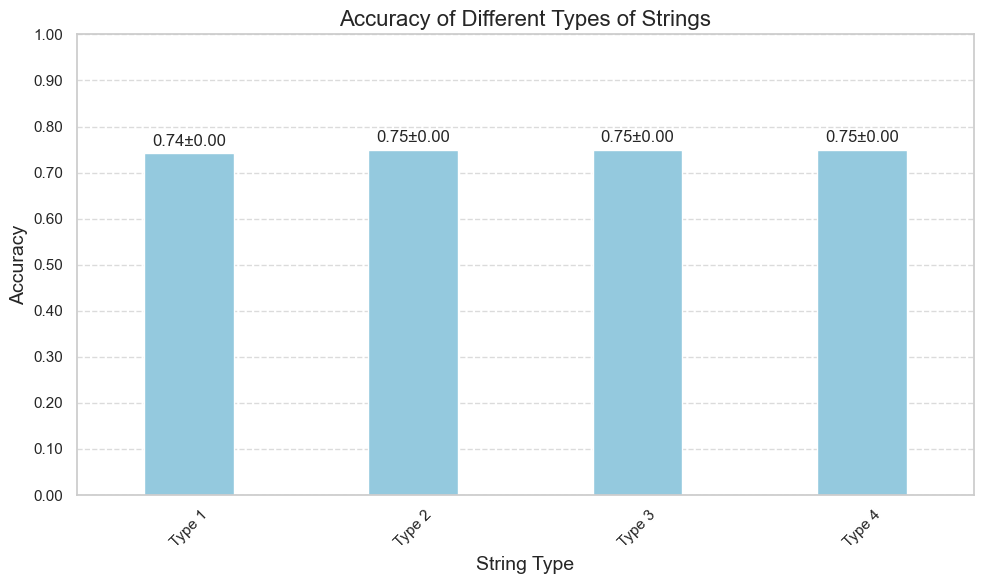

In [41]:
averages = {
    "m1": m1,
    "m2": m2,
    "m4": m4,
    "m6": m6
}
stds = {
    "std1": std1,
    "std2": std2,
    "std4": std4,
    "std6": std6
}

# histogram
import matplotlib.pyplot as plt
import numpy as np  
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker


# Set the style
sns.set(style="whitegrid")
# Create a DataFrame
data = {
    'Type': ['Type 1', 'Type 2', 'Type 3', 'Type 4'],
    'Accuracy': [m1, m2, m4, m6],
    'Std': [std1, std2, std4, std6]
}
df = pd.DataFrame(data)
# Create a bar plot with error bars
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(
    x='Type',
    y='Accuracy',
    data=df,
    color="skyblue",           # or color="#4A7BB7" etc.
    capsize=.2,
    errorbar="sd",              # instead of ci="sd"
    width=0.4  
)
for idx, row in df.iterrows():
    # x-position at the center of each bar
    x = idx
    # y-position just above the error bar cap
    y = row.Accuracy + row.Std + 0.01
    bar_plot.text(
        x, y,
        f"{row.Accuracy:.2f}±{row.Std:.2f}",
        ha="center",
        va="bottom",
        fontsize=12
    )

# Set the title and labels
plt.title('Accuracy of Different Types of Strings', fontsize=16)
plt.xlabel('String Type', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1)
# Customize the y-axis ticks
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Show the plot
plt.tight_layout()
plt.savefig("accuracy_histogram.png")
plt.show()

### Step 2: Multi-turn

In [54]:
gold_labels = load_expected_labels(toy_digits_and_one_cap_path)
classification_prompt = build_classification_prompt(
    toy_digits_and_one_cap_path,
    intro="You are a helpful assistant.",
    question="Label each test input True or False:",
    instructions="Return only True or False after each arrow."
)
print(classification_prompt)

You are a helpful assistant.
Return only True or False after each arrow.

### Training examples
"108362" -> False
"870873" -> False
"654876" -> False
"898991" -> False
"N42330" -> True
"342008" -> False
"633J76" -> True
"525H27" -> True
"825213" -> False
"6357W3" -> True
"7025Y3" -> True
"5C1905" -> True
"431740" -> False
"201877" -> False
"752698" -> False
"434252" -> False
"725408" -> False
"958E38" -> True
"89273B" -> True
"448560" -> False
"242399" -> False
"263837" -> False
"228388" -> False
"964R48" -> True
"203126" -> False
"B41826" -> True
"770468" -> False
"570611" -> False
"4J8388" -> True
"674283" -> False
"115359" -> False
"323922" -> False
"4413A0" -> True
"020521" -> False
"332113" -> False
"681116" -> False
"335972" -> False
"234773" -> False
"0673F6" -> True
"D95719" -> True
"F23737" -> True
"55U251" -> True
"261602" -> False
"382972" -> False
"5S5198" -> True
"806719" -> False
"903814" -> False
"843583" -> False
"110298" -> False
"51L011" -> True

### Label each test i

In [55]:
explain_prompt = "Now that you've classified all the test inputs, please explain the rule you used to determine whether an input should be labeled as True or False. Be as precise and specific as possible."

In [56]:
results = classify_then_explain(
    first_prompt=classification_prompt,        # built with build_classification_prompt
    second_prompt=explain_prompt,   # built with build_articulation_prompt (or custom)
    model_name=openai_4op1,
    dataset_json=toy_digits_and_one_cap_path,
    temperature=0.7,
    num_runs=3,
)

Run 1: acc 1.000
Run 2: acc 1.000
Run 3: acc 1.000
✅ Classification finished: mean acc 1.000 (±0.000) across 3 runs

📝 Explanation from last run:

Certainly! The rule for labeling the inputs as True or False is as follows:

- Label as True if the input contains at least one uppercase letter (A-Z).
- Label as False if the input consists only of digits (0-9), with no uppercase letters.

**Details:**
- The input string can be of any length, but in your examples, all are six characters.
- It does not matter where the uppercase letter appears—at the beginning, middle, or end.
- If there is at least one letter (A-Z), even if the rest are digits, label as True.
- If the string contains only digits (0-9) with no letters, label as False.

**Examples:**
- "633J76" → contains "J" → True
- "431740" → only digits → False
- "958E38" → contains "E" → True
- "752698" → only digits → False

No other factors (such as the number or position of letters/digits, or specific letters or digits) seem relevant 

In [57]:
explain_prompt = "Let's check your understanding of the classification task you just performed. What specific feature or characteristic were you looking for in each input to determine its label? Explain your decision process."

results = classify_then_explain(
    first_prompt=classification_prompt,        # built with build_classification_prompt
    second_prompt=explain_prompt,   # built with build_articulation_prompt (or custom)
    model_name=openai_4op1,
    dataset_json=toy_digits_and_one_cap_path,
    temperature=0.7,
    num_runs=3,
)

Run 1: acc 1.000
Run 2: acc 1.000
Run 3: acc 1.000
✅ Classification finished: mean acc 1.000 (±0.000) across 3 runs

📝 Explanation from last run:

The specific feature I was looking for is whether the input string contains at least one uppercase letter (A-Z). 

**Decision process:**
- If the string consists entirely of digits (0-9), I label it as **False**.
- If the string contains at least one uppercase letter (A-Z) anywhere in the string, I label it as **True**.

This is based on the provided training examples, where all strings labeled **True** contain at least one uppercase letter, and all labeled **False** are purely numeric.


In [58]:
explain_prompt = """
Let's probe your understanding deeper. According to the rule you're using, how would you classify these edge cases?

"123456" -> 
"ABCDEF" -> 
"abc123" -> 
"123b45" -> 
"AB3CD4" -> 
"12a45B" -> 

After classifying them, please explain whether your original rule still holds or needs modification."""

results = classify_then_explain(
    first_prompt=classification_prompt,        # built with build_classification_prompt
    second_prompt=explain_prompt,   # built with build_articulation_prompt (or custom)
    model_name=openai_4op1,
    dataset_json=toy_digits_and_one_cap_path,
    temperature=0.7,
    num_runs=10,
)

Run 1: acc 1.000
Run 2: acc 1.000
Run 3: acc 1.000
Run 4: acc 1.000
Run 5: acc 1.000
Run 6: acc 1.000
Run 7: acc 1.000
Run 8: acc 1.000
Run 9: acc 1.000
Run 10: acc 1.000
✅ Classification finished: mean acc 1.000 (±0.000) across 10 runs

📝 Explanation from last run:

"123456" -> False  
"ABCDEF" -> True  
"abc123" -> True  
"123b45" -> True  
"AB3CD4" -> True  
"12a45B" -> True  

**Explanation:**

Based on the training examples, the rule I used is:  
- If the string contains at least one letter (uppercase or lowercase), return True.  
- If the string is made up only of digits, return False.

**Reviewing the edge cases:**
- "123456" → all digits → False
- "ABCDEF" → all letters → True
- "abc123" → contains letters and digits → True
- "123b45" → contains a letter → True
- "AB3CD4" → contains letters and digits → True
- "12a45B" → contains letters and digits → True

**Does the rule still hold?**
Yes, the rule holds for these edge cases. The logic is: return True if there is at least one 

In [59]:
for explaination in results['explanations']:
    print(explaination)
    print("--------------------")

"123456" -> False  
"ABCDEF" -> True  
"abc123" -> True  
"123b45" -> True  
"AB3CD4" -> True  
"12a45B" -> True  

**Explanation:**

From the training examples, the rule is:  
- True if the string contains at least one letter (A-Z or a-z).  
- False if the string contains only digits.

**Edge Case Analysis:**
- "123456" -> Only digits, so False.
- "ABCDEF" -> Only letters, so True.
- "abc123" -> Contains letters and digits, so True.
- "123b45" -> Contains a letter, so True.
- "AB3CD4" -> Contains letters and digits, so True.
- "12a45B" -> Contains letters and digits, so True.

**Rule Check:**
The rule still holds for these edge cases:  
- Any string containing at least one letter (uppercase or lowercase) is classified as True.
- Only digit strings are False.

No modification is needed for the original rule.
--------------------
"123456" -> False  
"ABCDEF" -> True  
"abc123" -> True  
"123b45" -> True  
"AB3CD4" -> True  
"12a45B" -> True  

**Explanation:**  
The original rule I foll